Первоначальная версия датасета содержит 17 полей со следующей информацией:

hotel_address — адрес отеля;

review_date — дата, когда рецензент разместил соответствующий отзыв;

average_score — средний балл отеля, рассчитанный на основе последнего комментария за последний год;

hotel_name — название отеля;

reviewer_nationality — страна рецензента;

negative_review — отрицательный отзыв, который рецензент дал отелю;

review_total_negative_word_counts — общее количество слов в отрицательном отзыв;

positive_review — положительный отзыв, который рецензент дал отелю;

review_total_positive_word_counts — общее количество слов в положительном отзыве.

reviewer_score — оценка, которую рецензент поставил отелю на основе своего опыта;

total_number_of_reviews_reviewer_has_given — количество отзывов, которые рецензенты дали в прошлом;

total_number_of_reviews — общее количество действительных отзывов об отеле;

tags — теги, которые рецензент дал отелю;

days_since_review — количество дней между датой проверки и датой очистки;

additional_number_of_scoring — есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.

lat — географическая широта отеля;

lng — географическая долгота отеля.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sf-booking/hotels_test.csv
/kaggle/input/sf-booking/hotels_train.csv
/kaggle/input/sf-booking/submission.csv


In [2]:
import pandas as pd
import re
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split  
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [3]:
DATA_DIR = '/kaggle/input/sf-booking/'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') 
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv')
submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн

df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, поэтому пока что заполняем нулями

df = pd.concat([df_test, df_train], sort=False).reset_index(drop=True) # объединяем
df.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102,0,0.0
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443,0,0.0
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520,0,0.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

# Удаление строковых значений

## Дата отзыва (review_date)
Преобразуем дату в три отдельных признака:

- Год отзыва

- Месяц отзыва

- Количество дней с момента отзыва


In [5]:
df['review_date'] = pd.to_datetime(df['review_date'])
df['review_year'] = df['review_date'].dt.year
df['review_month'] = df['review_date'].dt.month

## Анализ длины отзывов (negative_review и positive_review)

Есть столбцы review_total_negative_word_counts и review_total_positive_word_counts, но можно ещё вычислить длину текста в символах.

In [6]:
df['negative_review_lenght'] = df['negative_review'].apply(len)
df['positive_review_lenght'] = df['positive_review'].apply(len)

display(df['negative_review_lenght'], df['positive_review_lenght'])

0         262
1          44
2           9
3          11
4          11
         ... 
515733     11
515734     11
515735     52
515736     11
515737    105
Name: negative_review_lenght, Length: 515738, dtype: int64

0         337
1          11
2          27
3         155
4          32
         ... 
515733     35
515734    436
515735     47
515736     28
515737    114
Name: positive_review_lenght, Length: 515738, dtype: int64

## Разбор тегов (tags)

In [7]:
df['tags'] = df['tags'].apply(lambda x: [tag.strip() for tag in x.strip('[]').replace(' ', '').split(',') if tag.strip()] if isinstance(x, str) else [])

In [8]:
# Выведем несколько тегов, чтобы проверить их содержимое
for i in range(5):  # проверим первые 5 строк
    print(f"Row {i}: {df['tags'][i]}")


Row 0: ["'Leisuretrip'", "'Couple'", "'DoubleRoom'", "'Stayed2nights'"]
Row 1: ["'Leisuretrip'", "'Group'", "'TripleRoom'", "'Stayed1night'"]
Row 2: ["'Businesstrip'", "'Solotraveler'", "'TwinRoom'", "'Stayed1night'", "'Submittedfromamobiledevice'"]
Row 3: ["'Leisuretrip'", "'Couple'", "'AmbassadorJuniorSuite'", "'Stayed1night'"]
Row 4: ["'Businesstrip'", "'Solotraveler'", "'ClassicDoubleorTwinRoom'", "'Stayed2nights'", "'Submittedfromamobiledevice'"]


In [9]:
# Убираем кавычки и заменяем нужные слова
df['tags'] = df['tags'].apply(lambda x: [tag.strip("'").replace('Leisuretrip', 'Leisure trip').replace('Businesstrip', 'Business trip') for tag in x])

# Выведем несколько строк с тегами, чтобы убедиться в исправлениях
for i in range(5):
    print(f"Строка {i}: {df['tags'][i]}")


Строка 0: ['Leisure trip', 'Couple', 'DoubleRoom', 'Stayed2nights']
Строка 1: ['Leisure trip', 'Group', 'TripleRoom', 'Stayed1night']
Строка 2: ['Business trip', 'Solotraveler', 'TwinRoom', 'Stayed1night', 'Submittedfromamobiledevice']
Строка 3: ['Leisure trip', 'Couple', 'AmbassadorJuniorSuite', 'Stayed1night']
Строка 4: ['Business trip', 'Solotraveler', 'ClassicDoubleorTwinRoom', 'Stayed2nights', 'Submittedfromamobiledevice']


In [10]:
# Создадим бинарные признаки
df['is_business_trip'] = df['tags'].apply(lambda x: 1 if 'Business trip' in x else 0)
df['is_leisure_trip'] = df['tags'].apply(lambda x: 1 if 'Leisure trip' in x else 0)

# Проверим результат
display(df['is_business_trip'], df['is_leisure_trip'])


0         0
1         0
2         1
3         0
4         1
         ..
515733    0
515734    0
515735    1
515736    0
515737    0
Name: is_business_trip, Length: 515738, dtype: int64

0         1
1         1
2         0
3         1
4         0
         ..
515733    1
515734    1
515735    0
515736    1
515737    1
Name: is_leisure_trip, Length: 515738, dtype: int64

In [11]:
def extract_stay_duration(tags):
    for tag in tags:
        match = re.search(r'Stayed(\d+)night?', tag) # Ищем "StayedXnights" (X — число)  
        if match:
            return int(match.group(1)) # Извлекаем число
    return 0 # Если тег не найден

df['stay_duration'] = df['tags'].apply(extract_stay_duration)

In [12]:
print(df[['tags', 'stay_duration']].head(10))

                                                tags  stay_duration
0  [Leisure trip, Couple, DoubleRoom, Stayed2nights]              2
1    [Leisure trip, Group, TripleRoom, Stayed1night]              1
2  [Business trip, Solotraveler, TwinRoom, Stayed...              1
3  [Leisure trip, Couple, AmbassadorJuniorSuite, ...              1
4  [Business trip, Solotraveler, ClassicDoubleorT...              2
5  [Business trip, Solotraveler, StandardDoubleor...              1
6    [Leisure trip, Couple, QueenRoom, Stayed1night]              1
7  [Business trip, Solotraveler, ExecutiveRoom, S...              3
8            [Group, DoubleorTwinRoom, Stayed1night]              1
9  [Couple, StandardTripleRoom, Stayed2nights, Su...              2


## Можем извлечь страну из hotel_address

In [13]:
df['hotel_country'] = df['hotel_address'].apply(lambda x: 'United Kingdom' if x.endswith('Kingdom') else x.split()[-1])
display(df[['hotel_address', 'hotel_country']])

,hotel_address,hotel_country
0,Via Senigallia 6 20161 Milan Italy,Italy
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,Netherlands
2,Mallorca 251 Eixample 08008 Barcelona Spain,Spain
3,Piazza Della Repubblica 17 Central Station 201...,Italy
4,Singel 303 309 Amsterdam City Center 1012 WJ A...,Netherlands
...,...,...
515733,9 Knaresborough Place Kensington and Chelsea L...,United Kingdom
515734,Landstra er Hauptstra e 155 03 Landstra e 1030...,Austria
515735,29 31 Gower Street Camden London WC1E 6HG Unit...,United Kingdom
515736,31 Great Cumberland Place Westminster Borough ...,United Kingdom


## Можем сравнить reviewer_nationality с hotel_country и, например, создать бинарный признак:

- 1, если рецензент из той же страны, что и отель (локальный)

- 0, если из другой (иностранный)

In [14]:
def match_countries(hotel_country, reviewer_nationality):
    # Удаляем пробелы в стране рецензента
    reviewer_nationality = reviewer_nationality.strip()
    
    # Сравниваем и возвращаем 1, если совпадают, 0 если нет
    return 1 if hotel_country == reviewer_nationality else 0

# Применяем функцию к данным
df['is_same_country'] = df.apply(lambda row: match_countries(row['hotel_country'], row['reviewer_nationality']), axis=1)

display(df[['reviewer_nationality', 'hotel_address', 'hotel_country', 'is_same_country']].head())

,reviewer_nationality,hotel_address,hotel_country,is_same_country
0,United Kingdom,Via Senigallia 6 20161 Milan Italy,Italy,0
1,Belgium,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,Netherlands,0
2,Sweden,Mallorca 251 Eixample 08008 Barcelona Spain,Spain,0
3,United States of America,Piazza Della Repubblica 17 Central Station 201...,Italy,0
4,United Kingdom,Singel 303 309 Amsterdam City Center 1012 WJ A...,Netherlands,0


## Закодируем страны

In [15]:
# Создаем список уникальных стран из столбца 'hotel_country'
hotel_countries = df['hotel_country'].unique()

# Создаем словарь для кодирования
country_mapping = {country.strip(): idx for idx, country in enumerate(hotel_countries)}

# Функция для кодирования стран
def encode_country(country):
    # Убираем пробелы и лишние символы
    country = country.strip()
    # Проверяем, если страна есть в нашем списке, то возвращаем код
    return country_mapping.get(country, len(country_mapping))

# Применяем функцию к столбцам
df['hotel_country_code'] = df['hotel_country'].apply(encode_country)
df['reviewer_country_code'] = df['reviewer_nationality'].apply(encode_country)

# Проверим результат
display(df[['hotel_country', 'hotel_country_code', 'reviewer_nationality', 'reviewer_country_code', 'is_same_country']].head())

print(country_mapping)

,hotel_country,hotel_country_code,reviewer_nationality,reviewer_country_code,is_same_country
0,Italy,0,United Kingdom,3,0
1,Netherlands,1,Belgium,6,0
2,Spain,2,Sweden,6,0
3,Italy,0,United States of America,6,0
4,Netherlands,1,United Kingdom,3,0


{'Italy': 0, 'Netherlands': 1, 'Spain': 2, 'United Kingdom': 3, 'France': 4, 'Austria': 5}


### Результаты кордирования:
- 'United Kingdom': 0 
- 'France': 1
- 'Netherlands': 2
- 'Italy': 3
- 'Austria': 4
- 'Spain': 5
- Другие : 6

# Очистка от пропущенных значений.

In [16]:
# Проверка на наличие пропусков после обработки
print(df.isnull().sum())


hotel_address                                    0
additional_number_of_scoring                     0
review_date                                      0
average_score                                    0
hotel_name                                       0
reviewer_nationality                             0
negative_review                                  0
review_total_negative_word_counts                0
total_number_of_reviews                          0
positive_review                                  0
review_total_positive_word_counts                0
total_number_of_reviews_reviewer_has_given       0
tags                                             0
days_since_review                                0
lat                                           3268
lng                                           3268
sample                                           0
reviewer_score                                   0
review_year                                      0
review_month                   

**Пропущенные значения составляют примерно 0.63% (2448 из 386803). Это немного, так что удаление не сильно повлияет, но всё же лучше заполнить пропуски.**

Можно проверить, как сильно разбросаны координаты внутри каждой страны.

In [17]:
country_std = df.groupby('hotel_country_code')[['lat', 'lng']].std()
overall_std = df[['lat', 'lng']].std()

print("Стандартное отклонение координат по странам:\n", country_std)
print("\nОбщее стандартное отклонение по всем данным:\n", overall_std)

Стандартное отклонение координат по странам:
                          lat       lng
hotel_country_code                    
0                   0.021204  0.024135
1                   0.019057  0.031256
2                   0.012095  0.021200
3                   0.016864  0.063752
4                   0.014166  0.026136
5                   0.013827  0.023796

Общее стандартное отклонение по всем данным:
 lat    3.466325
lng    4.579425
dtype: float64


Стандартное отклонение координат внутри стран (≈0.01–0.02) намного меньше, чем общее (3.47 и 4.58).
Это значит, что отели в каждой стране не сильно разбросаны.

Лучший вариант — заменить на медиану координат внутри страны.

In [18]:
df['lat'] = df.groupby('hotel_country_code')['lat'].transform(lambda x: x.fillna(x.median()))
df['lng'] = df.groupby('hotel_country_code')['lng'].transform(lambda x: x.fillna(x.median()))


## Проверяем остались ли пропуски

In [19]:
print(df.isna().sum())

hotel_address                                 0
additional_number_of_scoring                  0
review_date                                   0
average_score                                 0
hotel_name                                    0
reviewer_nationality                          0
negative_review                               0
review_total_negative_word_counts             0
total_number_of_reviews                       0
positive_review                               0
review_total_positive_word_counts             0
total_number_of_reviews_reviewer_has_given    0
tags                                          0
days_since_review                             0
lat                                           0
lng                                           0
sample                                        0
reviewer_score                                0
review_year                                   0
review_month                                  0
negative_review_lenght                  

# Создание новых признаков.

**Сколько уникальных названий отелей представлено в наборе данных?**

In [20]:
unique_hotels = df['hotel_name'].nunique()
unique_hotels

1492

**Когда был оставлен самый свежий отзыв? Когда был оставлен самый первый отзыв?**

In [21]:
# Находим самый свежий и первый отзыв
most_recent_review = df['review_date'].max()
first_review = df['review_date'].min()

print(f"Самый свежий отзыв был оставлен: {most_recent_review.date()}")
print(f"Самый первый отзыв был оставлен: {first_review.date()}")

Самый свежий отзыв был оставлен: 2017-08-03
Самый первый отзыв был оставлен: 2015-08-04


**Сколько уникальных тегов представлено в наборе данных?**

In [22]:
# Собираем уникальные теги
unique_tags_set = set()

# Проходим по каждому списку тегов в столбце 'tags'
for tag_list in df['tags']:
    for tag in tag_list:  # Каждый tag — это строка
        # Разбиваем тег на отдельные слова по пробелам, если необходимо
        words = tag.split()  # Разбивает строку по пробелам
        for word in words:
            unique_tags_set.add(word)

# Количество уникальных тегов
unique_tags = len(unique_tags_set)
print(f"Количество уникальных тегов: {unique_tags}")

Количество уникальных тегов: 2428


**Какой тег представлен в наибольшем числе отзывов?**

In [23]:
# Собираем все теги в один список
all_tags = []

# Проходим по каждому списку тегов в столбце 'tags'
for tag_list in df['tags']:
    all_tags.extend(tag_list)  # Добавляем теги из каждого списка в общий список

# Подсчитываем количество каждого тега
tag_counts = Counter(all_tags)

# Находим тег с наибольшим количеством
most_common_tag = tag_counts.most_common(1)[0]

print(f"Тег, представленный в наибольшем числе отзывов: {most_common_tag[0]}, количество: {most_common_tag[1]}")


Тег, представленный в наибольшем числе отзывов: Leisure trip, количество: 417778


**На сколько ночей чаще всего останавливаются путешественники в отелях?**

In [24]:
most_common_night = df['stay_duration'].mode()[0]
most_common_night

1

## Определим уникальные типы номеров

In [25]:
# Множество для хранения уникальных типов номеров
unique_room_types = set()

# Перебираем все записи в столбце 'tags'
for i in range(len(df)):
    # Проверяем, есть ли хотя бы 3 элемента в списке тегов
    if len(df['tags'][i]) > 2:
        type_room = df['tags'][i][2]  # Извлекаем третий тег (тип номера)
        unique_room_types.add(type_room)  # Добавляем тип номера в множество (уникальные значения)

# Выводим количество уникальных типов номеров
print(len(unique_room_types))

2411


## Закодируем уникальные типы номеров

In [26]:
# Кодируем данные с помощью LabelEncoder
label_encoder = LabelEncoder()
df['encoded_room_type'] = label_encoder.fit_transform(df['tags'].apply(lambda x: x[2] if len(x) > 2 else None))

# Выводим первые несколько строк
print(df[['tags', 'encoded_room_type']].head())

                                                tags  encoded_room_type
0  [Leisure trip, Couple, DoubleRoom, Stayed2nights]                542
1    [Leisure trip, Group, TripleRoom, Stayed1night]               2267
2  [Business trip, Solotraveler, TwinRoom, Stayed...               2308
3  [Leisure trip, Couple, AmbassadorJuniorSuite, ...                 29
4  [Business trip, Solotraveler, ClassicDoubleorT...                156


In [27]:
# Удаляем все строковые столбцы
df = df.select_dtypes(exclude=['object'])

# Удаляем столбец review_date
df = df.drop(columns=['review_date'])

# Проверим результат
df.head()

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,lat,lng,sample,reviewer_score,...,review_month,negative_review_lenght,positive_review_lenght,is_business_trip,is_leisure_trip,stay_duration,is_same_country,hotel_country_code,reviewer_country_code,encoded_room_type
0,904,8.1,52,16670,62,1,45.533137,9.171102,0,0.0,...,7,262,337,0,1,2,0,0,3,542
1,612,8.6,10,5018,0,7,52.385649,4.834443,0,0.0,...,12,44,11,0,1,1,0,1,6,2267
2,46,8.3,3,351,5,15,41.393192,2.161520,0,0.0,...,11,9,27,1,0,1,0,2,6,2308
3,241,9.1,0,1543,27,9,45.479888,9.196298,0,0.0,...,10,11,155,0,1,1,0,0,6,29
4,834,9.1,0,4687,7,2,52.370545,4.888644,0,0.0,...,5,11,32,1,0,2,0,1,3,156


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 21 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   review_total_negative_word_counts           515738 non-null  int64  
 3   total_number_of_reviews                     515738 non-null  int64  
 4   review_total_positive_word_counts           515738 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 6   lat                                         515738 non-null  float64
 7   lng                                         515738 non-null  float64
 8   sample                                      515738 non-null  int64  
 9   reviewer_score                              515738 non-null  float64
 

## Анализ мультиколлинеарности

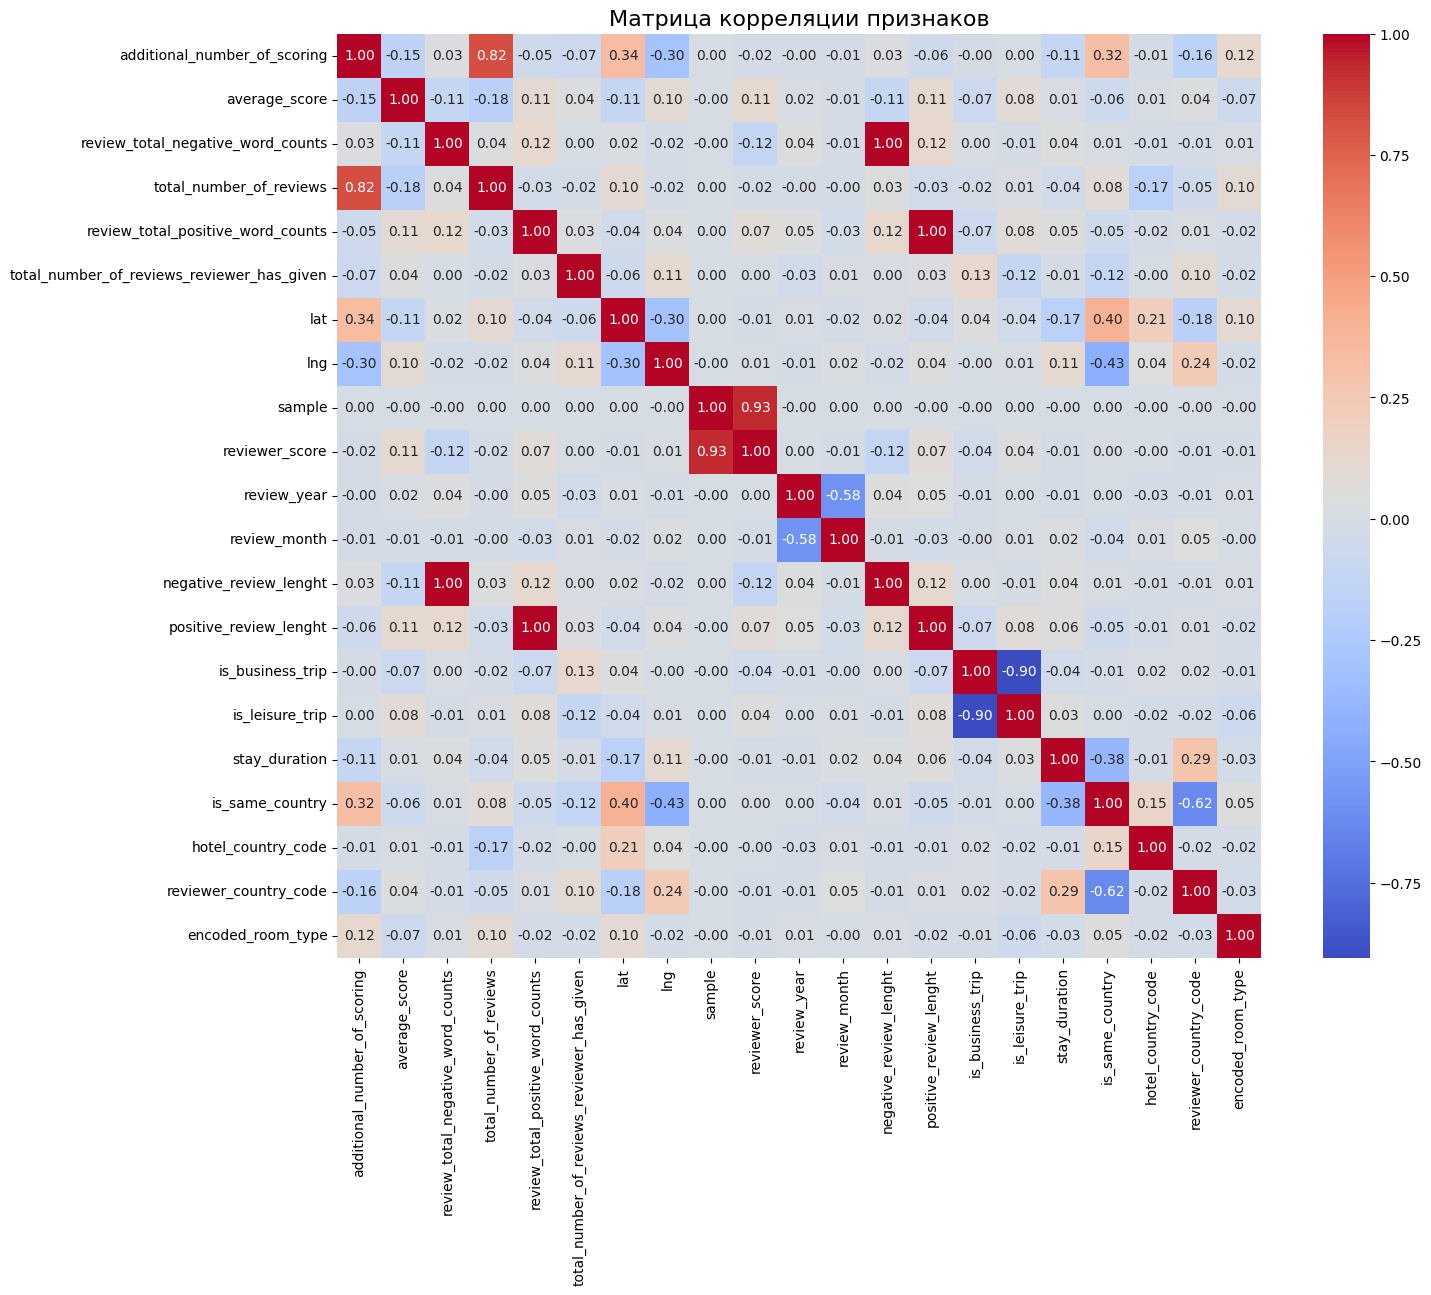

In [29]:
plt.figure(figsize=(16, 12))

# Строим корреляционную матрицу
corr_matrix = df.corr(numeric_only=True)

# Визуализируем
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Матрица корреляции признаков', fontsize=16)
plt.show()

**Удалим сильно коррелирующие признаки**

Используем корреляционную матрицу, чтобы найти пары признаков, которые имеют корреляцию выше заданного порога (например, 0.7). Мы удалим один из признаков из каждой пары, чтобы избежать мультиколлинеарности.

In [30]:
# Порог корреляции
threshold = 0.7

# Корреляционная матрица
corr_matrix = df.corr(numeric_only=True).abs()

# Получаем верхний треугольник матрицы (без дублирования)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Список признаков с высокой корреляцией
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

# Исключаем reviewer_score
if 'reviewer_score' in to_drop:
    to_drop.remove('reviewer_score')

# Удаляем признаки
df_reduced = df.drop(columns=to_drop)

# Список удалённых
print(f'Удаленные признаки: {to_drop}')

Удаленные признаки: ['total_number_of_reviews', 'negative_review_lenght', 'positive_review_lenght', 'is_leisure_trip']


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


**Проверим матрицу корреляций**

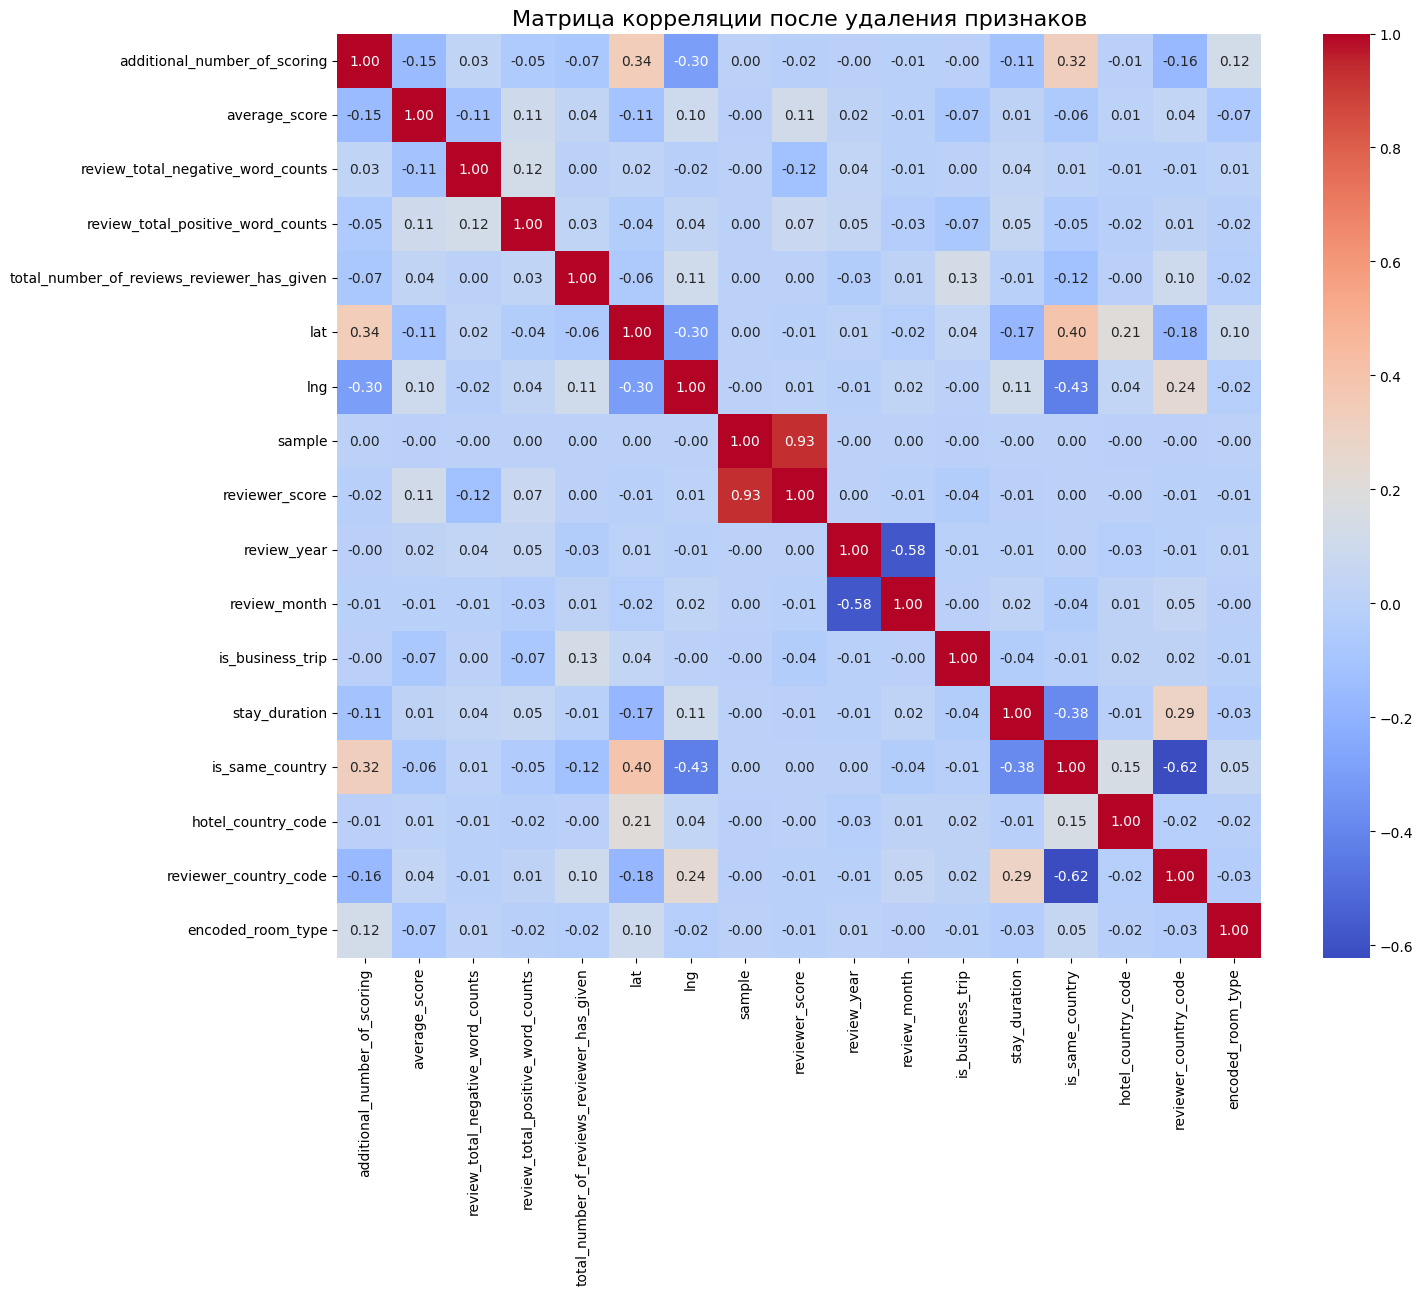

In [31]:
# Проверка новой корреляционной матрицы после удаления признаков
corr_matrix = df_reduced.corr()

# Визуализируем новую корреляционную матрицу
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Матрица корреляции после удаления признаков', fontsize=16)
plt.show()


## Разделим признаки по типу

In [32]:
# Непрерывные признаки
num_cols = [
    'additional_number_of_scoring',
    'review_total_negative_word_counts',
    'review_total_positive_word_counts',
    'total_number_of_reviews_reviewer_has_given',
    'average_score',
    'lat',
    'lng',
    'stay_duration'
]

# Категориальные признаки
cat_cols = [
    'review_year',
    'review_month',
    'is_business_trip',
    'is_same_country',
    'encoded_room_type'
]

## Разделим выборки на X и y

In [33]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей
X = df_reduced.drop(['reviewer_score'], axis=1)
y = df_reduced['reviewer_score']

# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" — для тестирования.  
# Для тестирования мы будем использовать 25 % от исходного датасета. 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

## Для оценки значимости категориальных признаков будем использовать тест хи-квадрат, для непрерывных признаков — тест ANOVA.

### Для оценки значимости категориальных переменных будем использовать непараметрический тест хи-квадрат

<Axes: >

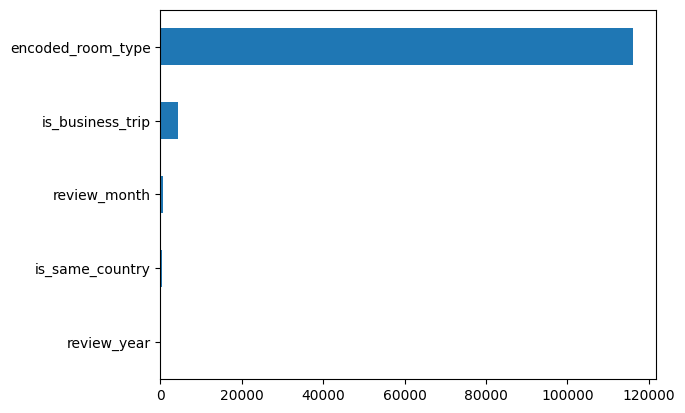

In [34]:
y = y.astype('int')

# Вычисляем значения хи-квадрат для категориальных признаков
imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index=cat_cols)

# Сортируем по важности
imp_cat.sort_values(inplace=True)

# Визуализируем
imp_cat.plot(kind='barh')

### Для оценки значимости непрерывных переменных будем использовать функцию f_classif из библиотеки sklearn.

<Axes: >

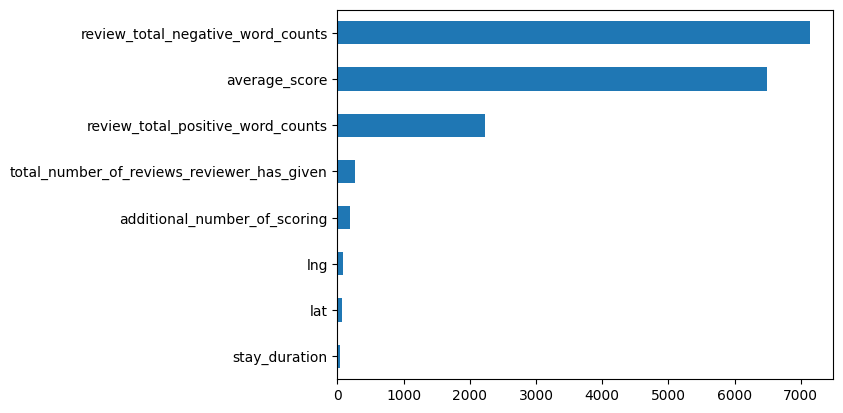

In [35]:
imp_num = pd.Series(f_classif(X[num_cols], y)[0], index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh')

## Создаём модель и делаем сабмишн

In [37]:
train_data = df.query('sample == 1').drop(['sample'], axis=1)
test_data = df.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values
X = train_data.drop(['reviewer_score'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)

In [38]:
# Удаляем reviewer_score из test_data, если он там случайно оказался
if 'reviewer_score' in test_data.columns:
    test_data = test_data.drop(columns=['reviewer_score'])

# Обучаем модель
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1)
model.fit(X_train, y_train)

# Предсказываем
y_pred = model.predict(test_data)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.4min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.7s finished


In [40]:
submission['reviewer_score'] = y_pred
submission.to_csv('submission.csv', index=False)